In [1]:
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import Dataset,DataLoader
import numpy as np
import torchvision
from torchvision import datasets, transforms 
from skimage.transform import resize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

import glob
from skimage import io
import cv2
import os


import time

뇌 shape:  (240, 240, 3)
[  0   1   2   3   4   5   6   8   9  10  11  12  13  15  16  17  18  19
  20  22  23  24  25  26  27  29  30  31  32  33  34  35  37  38  40  41
  42  44  45  47  48  49  51  52  54  55  56  58  59  61  62  64  65  66
  68  69  71  72  73  75  76  78  79  80  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 122 123 124 125 126 127
 128 129 130 131 132 134 135 136 137 138 139 140 141 142 143 145 146 147
 148 149 150 151 153 154 155 156 157 159 160 161 162 164 165 166 167 168
 170 171 172 173 175 176 177 178 179 181 182 183 184 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 217 218 219 220 221 222 224 226 230 231 234
 253 255]
종양 shape:  (240, 240, 3)
[  0 255]


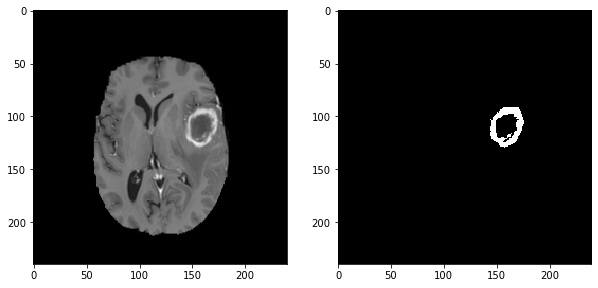

In [2]:
import cv2


fig=plt.figure(figsize=(10,5))

img =cv2.imread('./brain_tumour_final/train/brain_1.png')
# img =cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
ax1=plt.subplot(121)
ax1.imshow(img,cmap='gray')


img2 =  cv2.imread('./brain_tumour_final/train/tumour_1.png')
ax2=plt.subplot(122)
ax2.imshow(img2,cmap='gray')

print('뇌 shape: ',img.shape)
print(np.unique(img))

print('종양 shape: ',img2.shape)
print(np.unique(img2))

In [3]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else 'cpu')

In [6]:
EPOCHS=300
BATCH_SIZE=10

In [7]:
class ImageDataset(Dataset):
    
    def __init__(self, root, transform= None, mode ='train'):
        
        self.transform = transforms.Compose(transforms_)
        
        
        self.files = sorted(glob.glob(os.path.join(root,mode)+"*/*.*"))
        
        self.files_input =[f for f in self.files if f.startswith(f'./real\\{mode}\\brain')]
        self.files_label =[f for f in self.files if f.startswith(f'./real\\{mode}\\tumour')]
        
    def __getitem__(self, index):
        
        
        
        img_A = cv2.imread(self.files_input[index],0)
        img_B = cv2.imread(self.files_label[index],0)
        
        if img_A.ndim ==2:
            img_A=  img_A[:, :, np.newaxis]
        if img_B.ndim ==2:
            img_B=  img_B[:, :, np.newaxis]
        
        
        
        img_A = self.transform(img_A)
        img_B = self.transform(img_B)
    
        img_A= img_A.float()
        img_B= img_B.float()
        
        return {"A": img_A, "B": img_B}
    
    def __len__(self):
        return len(self.files_input)

In [8]:
transforms_ = [
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((240, 240), Image.BICUBIC),
    transforms.ToTensor()]

In [9]:
dataset_train= ImageDataset('./real/', transform=transforms_ ,mode ="train" )
dataset_vali = ImageDataset('./real/', transform=transforms_, mode="validation")
dataset_test = ImageDataset('./real/', transform=transforms_ , mode="test")

In [11]:
data= dataset_train.__getitem__(0)
inputs = data['A']
labels = data['B']
print(inputs.shape)
print(labels.shape)
print(inputs.type())
print(labels.type())

torch.Size([1, 240, 240])
torch.Size([1, 240, 240])
torch.FloatTensor
torch.FloatTensor


In [13]:
train_dataloader = DataLoader( dataset_train, batch_size=BATCH_SIZE, shuffle=True)#, num_workers=8,)

val_dataloader = DataLoader(    dataset_vali,    batch_size=BATCH_SIZE,    shuffle=True)#,    num_workers=1,)

test_dataloader = DataLoader(    dataset_test,    batch_size=BATCH_SIZE,    shuffle=True)#,    num_workers=1,)

In [16]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr


        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)
        

        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)
        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)
        return x

In [17]:
model = UNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_data_train = len(dataset_train)
num_data_val = len(dataset_vali)

num_batch_train = np.ceil(num_data_train / BATCH_SIZE).astype(int)
num_batch_val = np.ceil(num_data_val / BATCH_SIZE)

global val_losses
val_losses = []

global train_losses
train_losses = []

global test_losses
test_losses = []

In [18]:
def train(model, train_dataloader, optimizer, epoch):
    since= time.time()
    model.train()
    loss_arr = []

    for batch, data1 in enumerate(train_dataloader,1):
        accuracy=0
        data, target =  data1['A'].to(DEVICE), data1['B'].to(DEVICE)
        
        optimizer.zero_grad()
        
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, target)
        loss.backward()
        optimizer.step()
        loss_arr += [loss.item()]
        
        if(batch % 10 == 0):

            print(f"TRAIN: EPOCH {epoch:04d} / {EPOCHS:04d} | BATCH {batch:04d} / {num_batch_train:04d} | LOSS {np.mean(loss_arr):.4f}", end='')# | ACCURACY {batch_accuracy:.2f}", end=' ')
            
            time_elapsed = time.time() - since
            print('-- [time: {:.0f}m {:.0f}s]'.format(time_elapsed // 60, time_elapsed % 60))
            
    train_losses.append(sum(loss_arr)/ len(train_dataloader))

In [19]:
def vali_evaluate(model, val_dataloader):
    vali_avg=[]
    flag= False
    
    
    with torch.no_grad():
        model.eval()
        loss_arr = []
    
        for batch, data1 in enumerate(val_dataloader, 1):
            
            data, target =  data1['A'].to(DEVICE), data1['B'].to(DEVICE)
            
            output = model(data)
            
            vali_loss = F.binary_cross_entropy_with_logits(output, target)
            
            loss_arr+= [vali_loss.item()]
            vali_avg+= [vali_loss.item()]

            print("     VALID: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                          (epoch, EPOCHS, batch, num_batch_val, np.mean(loss_arr)))
    if(np.mean(loss_arr) < 0):
        flag= True
    val_losses.append(sum(loss_arr)/ len(val_dataloader))

    return np.mean(vali_avg), flag

In [20]:
global task_input
global task_output
global task_target

task_input= []
task_output=[]
task_target=[]

In [21]:
num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / 10)

fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

In [22]:
def evaluate(model, test_dataloader):
    model.load_state_dict(torch.load('최종model_unet.pt'))
    with torch.no_grad():
        model.eval()
        loss_arr = []
        dice_sum=[]
    
        for batch, data1 in enumerate(test_dataloader, 1):
            
            data, target =  data1['A'].to(DEVICE), data1['B'].to(DEVICE)
            
            output = model(data)
            
            loss = F.binary_cross_entropy_with_logits(output, target)
            
            
            loss_arr+= [loss.item()]
            print("TEST: BATCH %04d / %04d | LOSS %.4f" %
                  (batch, num_batch_test, np.mean(loss_arr)))
            


            task_input.append(data)
            task_output.append(output)
            task_target.append(target)
            
            output=torch.sigmoid(output)
            
            output=output.to('cpu').detach().numpy()
            target=target.to('cpu').detach().numpy()
            output[np.where(output>0.7)]=1.0
            output[np.where(output<=0.7)]=0.0
            
            
            dice=_dice_coefficient(output,target)
            dice=np.round(dice,3)*100
            dice_sum+=[dice]
            print(f'다이스계수:{dice} %')
            
    print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f" %
      (batch, num_batch_test, np.mean(loss_arr)))
    print(f'다이스 평균{np.round(np.mean(dice_sum),3)}% ')

In [24]:
temp=[]
valid_loss_min = np.inf
for epoch in range(1, EPOCHS+1):
    print('==========================================')
    train(model, train_dataloader, optimizer, epoch)
    print('==========================================')
    early,flag=vali_evaluate(model, val_dataloader)
    temp.append(early)
    
    if( early <0.02):
        optimizer = optim.Adam(model.parameters(), lr=5e-6)
    
    if early <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        early))
        torch.save(model.state_dict(), '최종model_unet.pt')
        valid_loss_min = early
    if(flag):
        print('Early Stop')
        break
        
    
    if(len(temp)>3):
        if(abs(temp[-1])<0.001):
            print('EARLY STOP')
            break
        if(temp[-3] <temp[-2]< temp[-1]):
            if(temp[-1]<0.05):
                print('EARLY STOP')
                break
print('==========================================')

TRAIN: EPOCH 0001 / 0300 | BATCH 0010 / 0070 | LOSS 0.6935-- [time: 0m 4s]
TRAIN: EPOCH 0001 / 0300 | BATCH 0020 / 0070 | LOSS 0.6337-- [time: 0m 8s]
TRAIN: EPOCH 0001 / 0300 | BATCH 0030 / 0070 | LOSS 0.5941-- [time: 0m 11s]
TRAIN: EPOCH 0001 / 0300 | BATCH 0040 / 0070 | LOSS 0.5634-- [time: 0m 15s]
TRAIN: EPOCH 0001 / 0300 | BATCH 0050 / 0070 | LOSS 0.5363-- [time: 0m 18s]
TRAIN: EPOCH 0001 / 0300 | BATCH 0060 / 0070 | LOSS 0.5128-- [time: 0m 21s]
TRAIN: EPOCH 0001 / 0300 | BATCH 0070 / 0070 | LOSS 0.4937-- [time: 0m 25s]
     VALID: EPOCH 0001 / 0300 | BATCH 0001 / 0005 | LOSS 0.4297
     VALID: EPOCH 0001 / 0300 | BATCH 0002 / 0005 | LOSS 0.4330
     VALID: EPOCH 0001 / 0300 | BATCH 0003 / 0005 | LOSS 0.4309
     VALID: EPOCH 0001 / 0300 | BATCH 0004 / 0005 | LOSS 0.4299
     VALID: EPOCH 0001 / 0300 | BATCH 0005 / 0005 | LOSS 0.4291
Validation loss decreased (inf --> 0.429076).  Saving model ...
TRAIN: EPOCH 0002 / 0300 | BATCH 0010 / 0070 | LOSS 0.3707-- [time: 0m 3s]
TRAIN: EPOC

In [25]:
def _dice_coefficient(predicted, target):
    smooth = 1
    product = np.multiply(predicted, target)
    intersection = np.sum(product)
    if(np.sum(predicted) + np.sum(target)==0):
         coefficient = (2*intersection + smooth) / \
        (np.sum(predicted) + np.sum(target) + smooth)
    else:
         coefficient = (2*intersection) / \
        (np.sum(predicted) + np.sum(target))
    return coefficient

In [26]:
print('real+aug data')
evaluate(model, test_dataloader)

real+aug data
TEST: BATCH 0001 / 0006 | LOSS 0.0155
다이스계수:75.9 %
TEST: BATCH 0002 / 0006 | LOSS 0.0146
다이스계수:75.0 %
TEST: BATCH 0003 / 0006 | LOSS 0.0143
다이스계수:71.8 %
TEST: BATCH 0004 / 0006 | LOSS 0.0146
다이스계수:81.3 %
TEST: BATCH 0005 / 0006 | LOSS 0.0151
다이스계수:74.7 %
TEST: BATCH 0006 / 0006 | LOSS 0.0152
다이스계수:83.0 %
AVERAGE TEST: BATCH 0006 / 0006 | LOSS 0.0152
다이스 평균76.95% 


In [28]:
def tran_img(a,b,c):
    b=torch.sigmoid(b)
    
    a=a.to('cpu').detach().numpy()
    b=b.to('cpu').detach().numpy()
    c=c.to('cpu').detach().numpy()
    
    a=a.transpose(1,2,0)
    b=b.transpose(1,2,0)
    c=c.transpose(1,2,0)
    
    a=np.squeeze(a)
    b=np.squeeze(b)
    c=np.squeeze(c)
    
    
    b[np.where(b>0.5)]=1.0
    b[np.where(b<=0.5)]=0.0
    
    return a,b,c


In [29]:
k=3
i=0
temp11=task_input[i][k]
temp12=task_output[i][k]
temp13=task_target[i][k]
i=1
temp21=task_input[i][k]
temp22=task_output[i][k]
temp23=task_target[i][k]
i=2
temp31=task_input[i][k]
temp32=task_output[i][k]
temp33=task_target[i][k]
i=3
temp41=task_input[i][k]
temp42=task_output[i][k]
temp43=task_target[i][k]

In [30]:
temp11,temp12,temp13 = tran_img(temp11,temp12,temp13)
temp21,temp22,temp23 = tran_img(temp21,temp22,temp23)
temp31,temp32,temp33 = tran_img(temp31,temp32,temp33)
temp41,temp42,temp43 = tran_img(temp41,temp42,temp43)

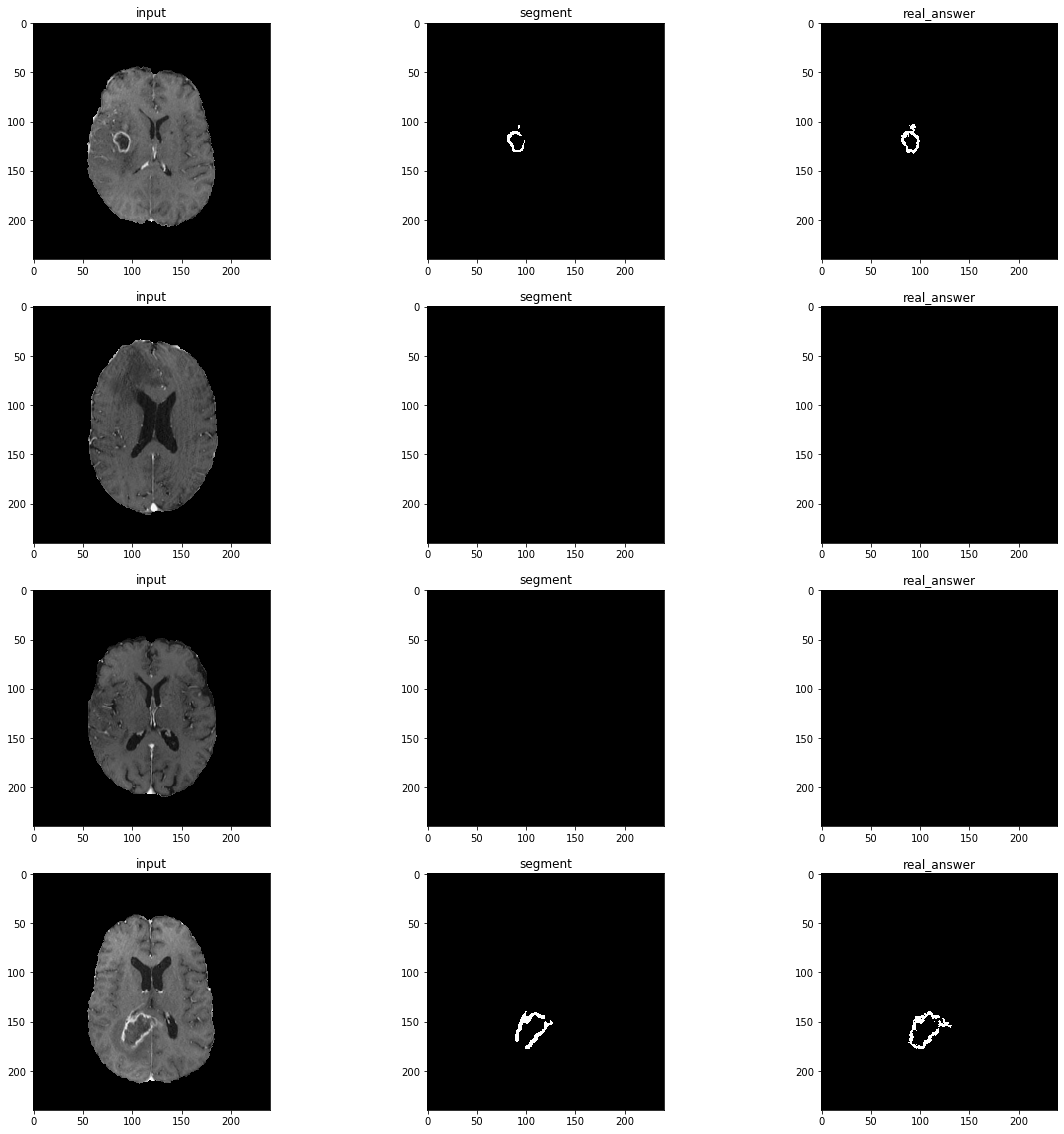

In [31]:
fig = plt.figure(figsize=(20, 20)) 

ax1=plt.subplot(431)
ax1.set_title('input')
ax1.imshow(temp11 , cmap='gray')
ax2=plt.subplot(432)
ax2.set_title('segment')

ax2.imshow(temp12, cmap='gray')
ax3=plt.subplot(433)
ax3.set_title('real_answer')
ax3.imshow(temp13, cmap='gray')


ax4=plt.subplot(434)
ax4.set_title('input')
ax4.imshow(temp21, cmap='gray')
ax5=plt.subplot(435)
ax5.set_title('segment')
ax5.imshow(temp22, cmap='gray')
ax6=plt.subplot(436)
ax6.set_title('real_answer')
ax6.imshow(temp23, cmap='gray')

ax7=plt.subplot(437)
ax7.set_title('input')
ax7.imshow(temp31, cmap='gray')
ax8=plt.subplot(438)
ax8.set_title('segment')
ax8.imshow(temp32, cmap='gray')
ax9=plt.subplot(439)
ax9.set_title('real_answer')
ax9.imshow(temp33, cmap='gray')

ax10=plt.subplot(4,3,10)
ax10.set_title('input')
ax10.imshow(temp41, cmap='gray')
ax11=plt.subplot(4,3,11)
ax11.set_title('segment')
ax11.imshow(temp42, cmap='gray')
ax12=plt.subplot(4,3,12)
ax12.set_title('real_answer')
ax12.imshow(temp43, cmap='gray')


fig = plt.gcf()
fig.savefig('./final_seg_1.png', dpi=fig.dpi)

In [231]:
from natsort import natsorted

In [232]:
transforms_ = [
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((240, 240), Image.BICUBIC),
    transforms.ToTensor(),
]


In [239]:
class ImageDataset(Dataset):
    
    def __init__(self, root, transform= None, mode ='train_final_seg'):
        
        self.transform = transforms.Compose(transforms_)
        
        
        self.files = sorted(glob.glob(os.path.join(root,mode)+"*/*.*"))

        self.files_input =[f for f in self.files if f.startswith(f'./real/all_brain\\{mode}\\brain')]
        self.files_label =[f for f in self.files if f.startswith(f'./real/all_brain\\{mode}\\tumour')]
        self.files_input=natsorted(self.files_input)
        self.files_label=natsorted(self.files_label)


    def __getitem__(self, index):
        img_A = cv2.imread(self.files_input[index],0)
        img_B = cv2.imread(self.files_label[index],0)
    
        if img_A.ndim ==2:
            img_A=  img_A[:, :, np.newaxis]
        if img_B.ndim ==2:
            img_B=  img_B[:, :, np.newaxis]

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)
    
        img_A= img_A.float()
        img_B= img_B.float()
        
        return {"A": img_A, "B": img_B}
    
    def __len__(self):
        return len(self.files_input)

In [240]:
dataset_all= ImageDataset('./real/all_brain/', transform=transforms,mode='result_input')
all_dataloader = DataLoader( dataset_all, batch_size=1, shuffle=False)

In [242]:
model.load_state_dict(torch.load('최종model_unet.pt'))
with torch.no_grad():
    model.eval()
    for batch, data1 in enumerate(all_dataloader, 1):

        data, target =  data1['A'].to(DEVICE), data1['B'].to(DEVICE)
        

        output = model(data)
        
        data=data[0]
        target= target[0]
        output=output[0]
        
        output=torch.sigmoid(output)
        
        data=data.to('cpu').detach().numpy()
        output=output.to('cpu').detach().numpy()
        target=target.to('cpu').detach().numpy()
    
        data=data.transpose(1,2,0)
        output=output.transpose(1,2,0)
        target=target.transpose(1,2,0)
    
        data=np.squeeze(data)
        output=np.squeeze(output)
        target=np.squeeze(target)
    
    
        output[np.where(output>0.7)]=1.0
        output[np.where(output<=0.7)]=0.0
        

        seg_input.append(data)
        seg_output.append(output)
        seg_target.append(target)


In [300]:
cnt=1
for img in seg_input:
    
    img=img*255
    cv2.imwrite(f'./real/all_brain/output_input/seg_{cnt}.png',img)
    cnt+=1

In [301]:
cnt=1
for img in seg_output:
    
    img=img*255
    cv2.imwrite(f'./real/all_brain/output_seg/seg_{cnt}.png',img)
    cnt+=1

In [302]:
cnt=1
for img in seg_target:
    
    img=img*255
    cv2.imwrite(f'./real/all_brain/output_target/seg_{cnt}.png',img)
    cnt+=1

In [313]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
from PIL import Image
import matplotlib.image as mpimg

path = [f"./real/all_brain/output_input_copy/{i}" for i in os.listdir("./real/all_brain/output_input_copy/")]
path=natsorted(path)
paths = [ Image.open(i) for i in path[::-1]]

imageio.mimsave('./real/all_brain/input.gif', paths, fps=15)

In [314]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
from PIL import Image
import matplotlib.image as mpimg

path = [f"./real/all_brain/output_seg_copy/{i}" for i in os.listdir("./real/all_brain/output_seg_copy/")]
path=natsorted(path)
paths = [ Image.open(i) for i in path[::-1]]

imageio.mimsave('./real/all_brain/seg.gif', paths, fps=15)

In [323]:
path_brain = [f"./real/all_brain/output_input_copy/{i}" for i in os.listdir("./real/all_brain/output_input_copy/")]
path_brain=natsorted(path_brain)
paths_brain = [ np.asarray(Image.open(i)) for i in path_brain]

path_seg = [f"./real/all_brain/output_seg_copy/{i}" for i in os.listdir("./real/all_brain/output_seg_copy/")]
path_seg=natsorted(path_seg)
paths_seg = [ np.asarray(Image.open(i)) for i in path_seg]


In [341]:
red_seg=[]

for i in range(len(paths_seg)):
    temp_brain = paths_brain[i].copy()
    temp_seg= paths_seg[i] .copy()
    brain_3c = cv2.cvtColor(temp_brain, cv2.COLOR_GRAY2RGB)
    
    brain_3c[np.where(temp_seg ==255)] =[255,255,0]
    
    im =Image.fromarray(np.uint8(brain_3c))
    red_seg.append(im)

imageio.mimsave('./real/all_brain/seg_red.gif', red_seg[::-1], fps=15)

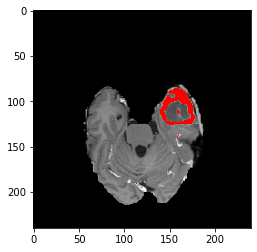

In [333]:
temp_brain = paths_brain[0].copy()
temp_seg= paths_seg[0] .copy()

brain_3c = cv2.cvtColor(temp_brain, cv2.COLOR_GRAY2RGB)

brain_3c[np.where(temp_seg ==255)] =[255,0,0]

plt.imshow(brain_3c )